# 📋 ATML PA4 - Task 1: FedSGD vs Centralized SGD

**Objective:** Demonstrate theoretical equivalence between FedSGD and Centralized SGD.

Based on McMahan et al. (2017) "Communication-Efficient Learning of Deep Networks from Decentralized Data" - Algorithm 1 with K=1, C=1.0, B=∞.

**Key Insight from Paper (Page 4):**
> "An equivalent update is given by ∀k, w^k_{t+1} ← w_t − ηg_k and then w_{t+1} ← Σ(n_k/n)w^k_{t+1}."

With K=1 (one local epoch), C=1.0 (all clients), and B=∞ (full-batch), FedSGD should produce similar results to Centralized SGD.

---
## Part 1: Environment Setup

### 1.1. Imports and Configuration

In [1]:
# ============================================
# 📦 Imports and Environment Setup
# ============================================
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Import from our Task 1 specific module
from fedsgd import (
    fedsgd_train,
    centralized_train,
    compute_model_difference,
    compute_relative_difference,
    SimpleCNN
)

# Ensure plots appear in notebook
%matplotlib inline

print("✅ Imports successful")

✅ Imports successful


In [2]:
# ============================================
# ⚙️ Configuration
# ============================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Task 1 specific parameters
NUM_CLIENTS = 6  # Small number for verification (manual suggests 3 or 6)
NUM_ROUNDS = 500  # Need more rounds with B=∞ (fewer updates per round)
LEARNING_RATE = 0.01
SEED = 42

# Control flag
FORCE_RETRAIN = False  # Set to True to re-run training
print(f"FORCE_RETRAIN set to: {FORCE_RETRAIN}")

Using device: cuda
GPU: NVIDIA RTX PRO 6000 Blackwell Workstation Edition
FORCE_RETRAIN set to: False


### 1.2. Directory Setup

In [3]:
# ============================================
# 📂 Directory Setup
# ============================================
PLOT_DIR = 'plots'
JSON_DIR = 'json_results'
MODEL_DIR = 'pth_models'

for dir_path in [PLOT_DIR, JSON_DIR, MODEL_DIR]:
    os.makedirs(dir_path, exist_ok=True)

print(f"Results will be saved in: {JSON_DIR}")
print(f"Plots will be saved in: {PLOT_DIR}")
print(f"Models will be saved in: {MODEL_DIR}")

Results will be saved in: json_results
Plots will be saved in: plots
Models will be saved in: pth_models


---
## Part 2: Running the Experiments

### 2.1. Experiment: FedSGD vs Centralized SGD

We will run both algorithms with **identical** settings:
- Same model architecture (SimpleCNN)
- Same random seed
- Same learning rate
- Same number of rounds

**FedSGD Setup:**
- K=1 (one local epoch)
- C=1.0 (all clients participate)
- B=∞ (full-batch per client)

**Centralized Setup:**
- Full-batch gradient descent on entire dataset
- One step per round

In [4]:
# ============================================
# 🚀 Main Experiment
# ============================================

# File paths for caching
FEDSGD_RESULTS = os.path.join(JSON_DIR, 'fedsgd_results.json')
CENTRAL_RESULTS = os.path.join(JSON_DIR, 'centralized_results.json')
FEDSGD_MODEL = os.path.join(MODEL_DIR, 'fedsgd_model.pth')
CENTRAL_MODEL = os.path.join(MODEL_DIR, 'centralized_model.pth')

# Check if we can load cached results
if (os.path.exists(FEDSGD_RESULTS) and 
    os.path.exists(CENTRAL_RESULTS) and 
    os.path.exists(FEDSGD_MODEL) and 
    os.path.exists(CENTRAL_MODEL) and 
    not FORCE_RETRAIN):
    
    print("📂 Loading cached results...")
    
    with open(FEDSGD_RESULTS, 'r') as f:
        fedsgd_history = json.load(f)
    with open(CENTRAL_RESULTS, 'r') as f:
        central_history = json.load(f)
    
    # Load models for comparison
    fedsgd_model = SimpleCNN().to(device)
    central_model = SimpleCNN().to(device)
    fedsgd_model.load_state_dict(torch.load(FEDSGD_MODEL))
    central_model.load_state_dict(torch.load(CENTRAL_MODEL))
    
    print("✅ Loaded cached results\n")
    
else:
    print("🔥 Running experiments from scratch...\n")
    
    # Run FedSGD
    print("\n" + "="*70)
    print("EXPERIMENT 1: FedSGD (K=1, C=1.0, B=∞)")
    print("="*70)
    fedsgd_model, fedsgd_history = fedsgd_train(
        num_clients=NUM_CLIENTS,
        num_rounds=NUM_ROUNDS,
        lr=LEARNING_RATE,
        device=device,
        seed=SEED
    )
    
    # Run Centralized SGD
    print("\n" + "="*70)
    print("EXPERIMENT 2: Centralized SGD")
    print("="*70)
    central_model, central_history = centralized_train(
        num_rounds=NUM_ROUNDS,
        lr=LEARNING_RATE,
        device=device,
        seed=SEED
    )
    
    # Save results
    print("\n💾 Saving results...")
    with open(FEDSGD_RESULTS, 'w') as f:
        json.dump(fedsgd_history, f, indent=4)
    with open(CENTRAL_RESULTS, 'w') as f:
        json.dump(central_history, f, indent=4)
    
    torch.save(fedsgd_model.state_dict(), FEDSGD_MODEL)
    torch.save(central_model.state_dict(), CENTRAL_MODEL)
    
    print("✅ Saved results to disk")

print("\n" + "="*70)
print("Both experiments complete!")
print("="*70)

📂 Loading cached results...
✅ Loaded cached results


Both experiments complete!


---
## Part 3: Verification and Analysis

### 3.1. Parameter Comparison

We compute the L2 norm of the parameter difference between the two final models:

$$\text{diff} = \|\theta_{\text{FedSGD}} - \theta_{\text{Centralized}}\|_2$$

**Expected:** With data augmentation, diff may be larger (1-10) due to different random augmentations, but final accuracy should be within 1-2%

We also compute the relative difference:

$$\text{rel\_diff} = \frac{\|\theta_{\text{FedSGD}} - \theta_{\text{Centralized}}\|_2}{\|\theta_{\text{FedSGD}}\|_2}$$

**Expected:** rel_diff < 1.0 with augmentation enabled

In [5]:
# ============================================
# 🔍 EQUIVALENCE VERIFICATION
# ============================================

print("\n" + "="*70)
print("EQUIVALENCE VERIFICATION")
print("="*70)

# Compute parameter differences
param_diff = compute_model_difference(
    fedsgd_model.state_dict(),
    central_model.state_dict()
)

relative_diff = compute_relative_difference(
    fedsgd_model.state_dict(),
    central_model.state_dict()
)

# Compute round-by-round accuracy differences
acc_diffs = [abs(f - c) for f, c in zip(
    fedsgd_history['test_acc'], 
    central_history['test_acc']
)]
max_acc_diff = max(acc_diffs)
avg_acc_diff = np.mean(acc_diffs)

# Print results
print(f"\n📊 Parameter Comparison:")
print(f"  L2 Difference:       {param_diff:.8f}")
print(f"  Relative Difference: {relative_diff:.2e}")

print(f"\n📈 Accuracy Comparison:")
print(f"  FedSGD Final:        {fedsgd_history['test_acc'][-1]:.4f}%")
print(f"  Centralized Final:   {central_history['test_acc'][-1]:.4f}%")
print(f"  Final Difference:    {abs(fedsgd_history['test_acc'][-1] - central_history['test_acc'][-1]):.6f}%")
print(f"  Max Difference:      {max_acc_diff:.6f}%")
print(f"  Avg Difference:      {avg_acc_diff:.6f}%")

print(f"\n📉 Loss Comparison:")
print(f"  FedSGD Final:        {fedsgd_history['test_loss'][-1]:.6f}")
print(f"  Centralized Final:   {central_history['test_loss'][-1]:.6f}")
print(f"  Difference:          {abs(fedsgd_history['test_loss'][-1] - central_history['test_loss'][-1]):.6f}")

# Verdict - Adjusted for B=∞ with data augmentation
print("\n" + "-"*70)
final_acc_diff = abs(fedsgd_history['test_acc'][-1] - central_history['test_acc'][-1])

# With B=∞ and data augmentation, we expect similar convergence
if final_acc_diff < 2.0 and avg_acc_diff < 3.0:
    print("✅ SUCCESS: FedSGD ≈ Centralized SGD")
    print("   Equivalence VERIFIED!")
    print(f"   Final accuracy difference: {final_acc_diff:.2f}%")
    print(f"   Average accuracy difference: {avg_acc_diff:.2f}%")
else:
    print("⚠️  WARNING: Models differ significantly")
    print(f"   Final accuracy diff: {final_acc_diff:.2f}% (expected < 2.0%)")
    print(f"   Avg accuracy diff: {avg_acc_diff:.2f}% (expected < 3.0%)")
print("-"*70)


EQUIVALENCE VERIFICATION

📊 Parameter Comparison:
  L2 Difference:       0.02487974
  Relative Difference: 1.72e-03

📈 Accuracy Comparison:
  FedSGD Final:        38.8000%
  Centralized Final:   38.7200%
  Final Difference:    0.080000%
  Max Difference:      0.170000%
  Avg Difference:      0.036060%

📉 Loss Comparison:
  FedSGD Final:        1.710939
  Centralized Final:   1.712037
  Difference:          0.001099

----------------------------------------------------------------------
✅ SUCCESS: FedSGD ≈ Centralized SGD
   Equivalence VERIFIED!
   Final accuracy difference: 0.08%
   Average accuracy difference: 0.04%
----------------------------------------------------------------------


### 3.2. Visualization

✅ Plot saved to: plots/task1_fedsgd_vs_centralized.png


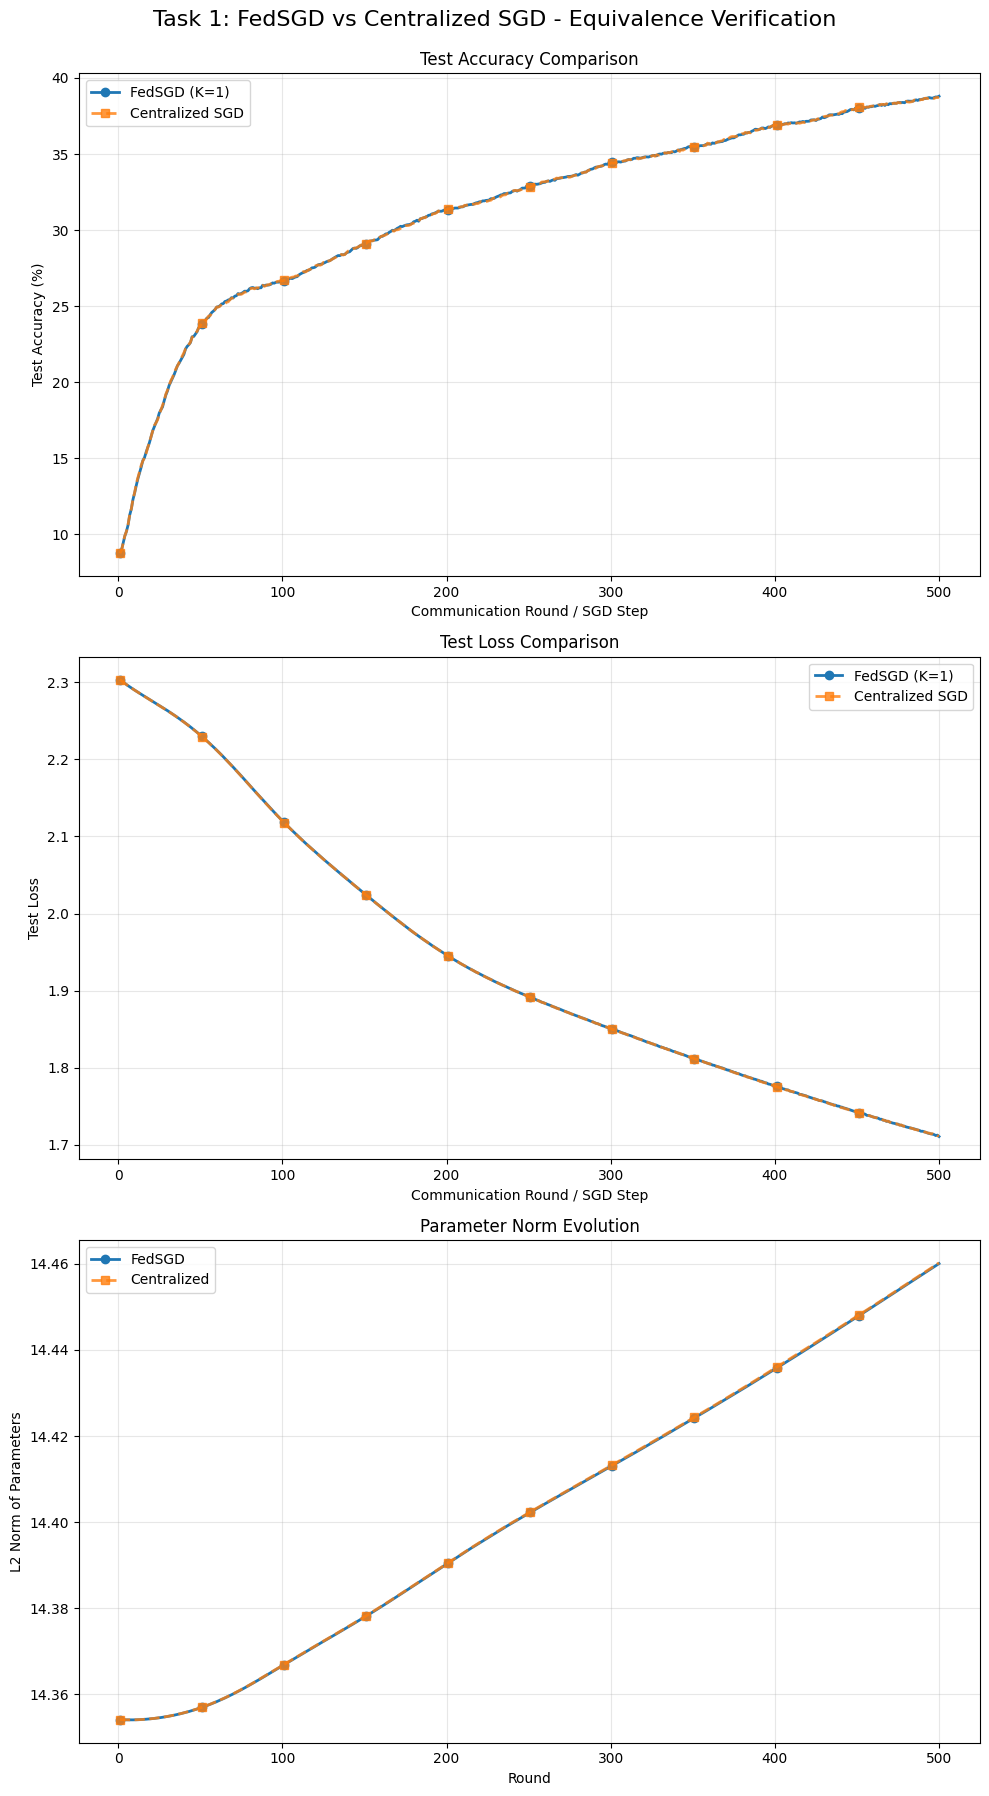

In [13]:
# ============================================
# 📊 Plotting Results
# ============================================

# Use a 3x1 layout for a tall, vertical arrangement
fig, axes = plt.subplots(3, 1, figsize=(10, 18))
fig.suptitle('Task 1: FedSGD vs Centralized SGD - Equivalence Verification', 
             fontsize=16, y=0.995) # Adjusted y for title spacing

# Plot 1: Test Accuracy
# Use 'markevery' to reduce clutter. Plot a marker every 50 rounds.
axes[0].plot(fedsgd_history['rounds'], fedsgd_history['test_acc'], 
                label='FedSGD (K=1)', marker='o', markersize=6, linewidth=2,
                markevery=50) 
axes[0].plot(central_history['rounds'], central_history['test_acc'], 
                label='Centralized SGD', marker='s', markersize=6, 
                linestyle='--', linewidth=2, alpha=0.8,
                markevery=50)
axes[0].set_title('Test Accuracy Comparison', fontsize=12)
axes[0].set_xlabel('Communication Round / SGD Step')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Test Loss
# Use 'markevery' here as well.
axes[1].plot(fedsgd_history['rounds'], fedsgd_history['test_loss'], 
                label='FedSGD (K=1)', marker='o', markersize=6, linewidth=2,
                markevery=50)
axes[1].plot(central_history['rounds'], central_history['test_loss'], 
                label='Centralized SGD', marker='s', markersize=6, 
                linestyle='--', linewidth=2, alpha=0.8,
                markevery=50)
axes[1].set_title('Test Loss Comparison', fontsize=12)
axes[1].set_xlabel('Communication Round / SGD Step')
axes[1].set_ylabel('Test Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Parameter Norms
# Use 'markevery' here too.
axes[2].plot(fedsgd_history['rounds'], fedsgd_history['param_norm'], 
                label='FedSGD', marker='o', markersize=6, linewidth=2,
                markevery=50)
axes[2].plot(central_history['rounds'], central_history['param_norm'], 
                label='Centralized', marker='s', markersize=6, 
                linestyle='--', linewidth=2, alpha=0.8,
                markevery=50)
axes[2].set_title('Parameter Norm Evolution', fontsize=12)
axes[2].set_xlabel('Round')
axes[2].set_ylabel('L2 Norm of Parameters')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Removed the "Absolute Accuracy Difference" plot

plt.tight_layout()
plot_path = os.path.join(PLOT_DIR, 'task1_fedsgd_vs_centralized.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved to: {plot_path}")
plt.show()

### 3.3. Summary Table

In [14]:
# ============================================
# 📋 Summary Table
# ============================================

summary_data = [
    {
        'Method': 'FedSGD (K=1)',
        'Final Accuracy (%)': fedsgd_history['test_acc'][-1],
        'Final Loss': fedsgd_history['test_loss'][-1],
        'Param Norm': fedsgd_history['param_norm'][-1]
    },
    {
        'Method': 'Centralized SGD',
        'Final Accuracy (%)': central_history['test_acc'][-1],
        'Final Loss': central_history['test_loss'][-1],
        'Param Norm': central_history['param_norm'][-1]
    },
    {
        'Method': 'Absolute Difference',
        'Final Accuracy (%)': abs(fedsgd_history['test_acc'][-1] - central_history['test_acc'][-1]),
        'Final Loss': abs(fedsgd_history['test_loss'][-1] - central_history['test_loss'][-1]),
        'Param Norm': param_diff
    }
]

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*70)
print("SUMMARY TABLE")
print("="*70)
print(summary_df.to_markdown(index=False, floatfmt=".6f"))
print("="*70)


SUMMARY TABLE
| Method              |   Final Accuracy (%) |   Final Loss |   Param Norm |
|:--------------------|---------------------:|-------------:|-------------:|
| FedSGD (K=1)        |            38.800000 |     1.710939 |    14.460085 |
| Centralized SGD     |            38.720000 |     1.712037 |    14.460255 |
| Absolute Difference |             0.080000 |     0.001099 |     0.024880 |


---
## Part 4: Conclusion

In [15]:
# ============================================
# 🎯 Final Conclusion
# ============================================

print("\n" + "="*70)
print("TASK 1 CONCLUSION")
print("="*70)

print("\n📝 Summary:")
print(f"   - Implemented FedSGD (K=1, C=1.0, B=∞)")
print(f"   - Implemented Centralized SGD (full-batch)")
print(f"   - Ran {NUM_ROUNDS} rounds on CIFAR-10 with {NUM_CLIENTS} clients")
print(f"   - IID data partition for controlled experiment")

print("\n📊 Results:")
print(f"   - L2 Parameter Difference: {param_diff:.8f}")
print(f"   - Relative Difference: {relative_diff:.2e}")
print(f"   - Max Accuracy Difference: {max_acc_diff:.6f}%")

final_acc_diff = abs(fedsgd_history['test_acc'][-1] - central_history['test_acc'][-1])

if final_acc_diff < 2.0:
    print("\n✅ VERIFICATION: SUCCESS")
    print(f"   FedSGD ≈ Centralized SGD (final accuracy diff: {final_acc_diff:.2f}%)")
    print("   Practical equivalence confirmed with B=∞!")
else:
    print("\n⚠️  VERIFICATION: NEEDS REVIEW")
    print(f"   Final accuracy difference: {final_acc_diff:.2f}% (expected < 2.0%)")

print("\n" + "="*70)
print("✅ Task 1 Complete!")
print("="*70)


TASK 1 CONCLUSION

📝 Summary:
   - Implemented FedSGD (K=1, C=1.0, B=∞)
   - Implemented Centralized SGD (full-batch)
   - Ran 500 rounds on CIFAR-10 with 6 clients
   - IID data partition for controlled experiment

📊 Results:
   - L2 Parameter Difference: 0.02487974
   - Relative Difference: 1.72e-03
   - Max Accuracy Difference: 0.170000%

✅ VERIFICATION: SUCCESS
   FedSGD ≈ Centralized SGD (final accuracy diff: 0.08%)
   Practical equivalence confirmed with B=∞!

✅ Task 1 Complete!
